In [1]:

# data manipulation
from g2p_client import G2PDatabase
import pandas as pd

# plotting
from IPython.display import set_matplotlib_formats
from __future__ import division
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#  The resulting plots will then also be stored in the notebook document, with big fonts
%matplotlib inline
sns.set(font_scale=2)

# our ES instance
INDEX = 'associations'
HOST = 'elastic'
DATABASE = G2PDatabase(HOST, INDEX)


In [2]:
# get a dataframe with features, environment, features and evidence
# ( for the details, pass verbose flag to print query)
associations_df = DATABASE.associations_dataframe(verbose=True)

{
    "query": {
        "query_string": {
            "query": "-source:*trials +features.start:* +association.phenotype.type:* +association.environmentalContexts.id:* "
        }
    },
    "_source": {
        "includes": [
            "source",
            "association.evidence_label",
            "genes",
            "association.phenotype.type.id",
            "association.phenotype.type.term",
            "association.environmentalContexts.id",
            "association.environmentalContexts.term",
            "association.evidence.info.publications",
            "features"
        ]
    }
}


In [6]:
# as we can see its panda friendly
print associations_df.shape
associations_df.head(4)

(21155, 19)


,environmentalContext.id,environmentalContext.term,evidence_label,feature.alt,feature.biomarker_type,feature.chromosome,feature.description,feature.end,feature.entrez_id,feature.geneSymbol,feature.name,feature.ref,feature.referenceName,feature.start,gene_list,phenotype.id,phenotype.term,publication_count,source
0,compound:CID3062316,DASATINIB,A,None,polymorphism,22,NaN,23632600.0,25.0,ABL1,BCR-ABL,None,GRCh37,23522397.0,ABL1,DOID:8552,chronic myeloid leukemia,1,civic
1,compound:CID3062316,DASATINIB,A,None,polymorphism,22,NaN,23632600.0,25.0,ABL1,BCR-ABL,None,GRCh37,23522397.0,ABL1,DOID:8552,chronic myeloid leukemia,1,civic
2,compound:CID644241,NILOTINIB,A,None,polymorphism,22,NaN,23632600.0,25.0,ABL1,BCR-ABL,None,GRCh37,23522397.0,ABL1,DOID:8552,chronic myeloid leukemia,1,civic
3,compound:CID644241,NILOTINIB,A,None,polymorphism,22,NaN,23632600.0,25.0,ABL1,BCR-ABL,None,GRCh37,23522397.0,ABL1,DOID:8552,chronic myeloid leukemia,1,civic


In [13]:
pd.pivot_table(associations_df, 
               index=['source', 'evidence_label'], 
               values=['gene_list'],
               aggfunc='count',
               fill_value=0,
               margins = True)

gene_list
source         evidence_label           
cgi            A                     224
               B                      13
               C                     202
               D                     195
civic          A                      80
               B                    1424
               C                    1352
               D                    2063
jax            A                     146
               B                     184
               C                    2142
               D                    9879
molecularmatch A                    1283
               B                     175
               C                     275
               D                    1195
oncokb         A                     124
               B                      38
               C                      53
               D                     108
All                                21155

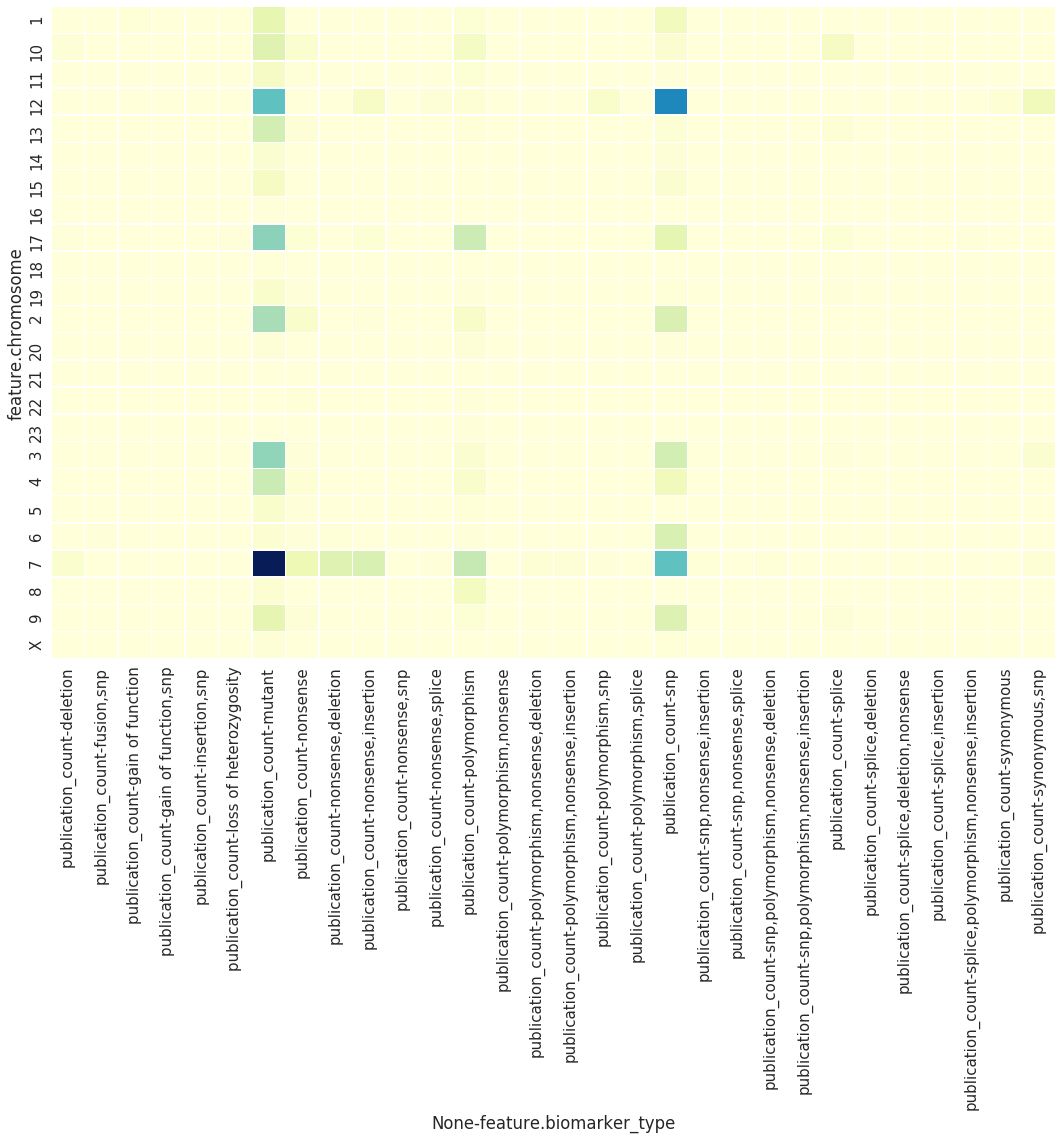

In [4]:
# create a pivot table to sum publication count 
table = pd.pivot_table(associations_df, 
                       values=['publication_count'], 
                       index=['feature.chromosome'],
                       columns=['feature.biomarker_type'], 
                       aggfunc=sum ,fill_value=0)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.set(font_scale=1.5)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(table, fmt="1.0f", linewidths=.5, ax=ax, cbar=False, cmap="YlGnBu") 



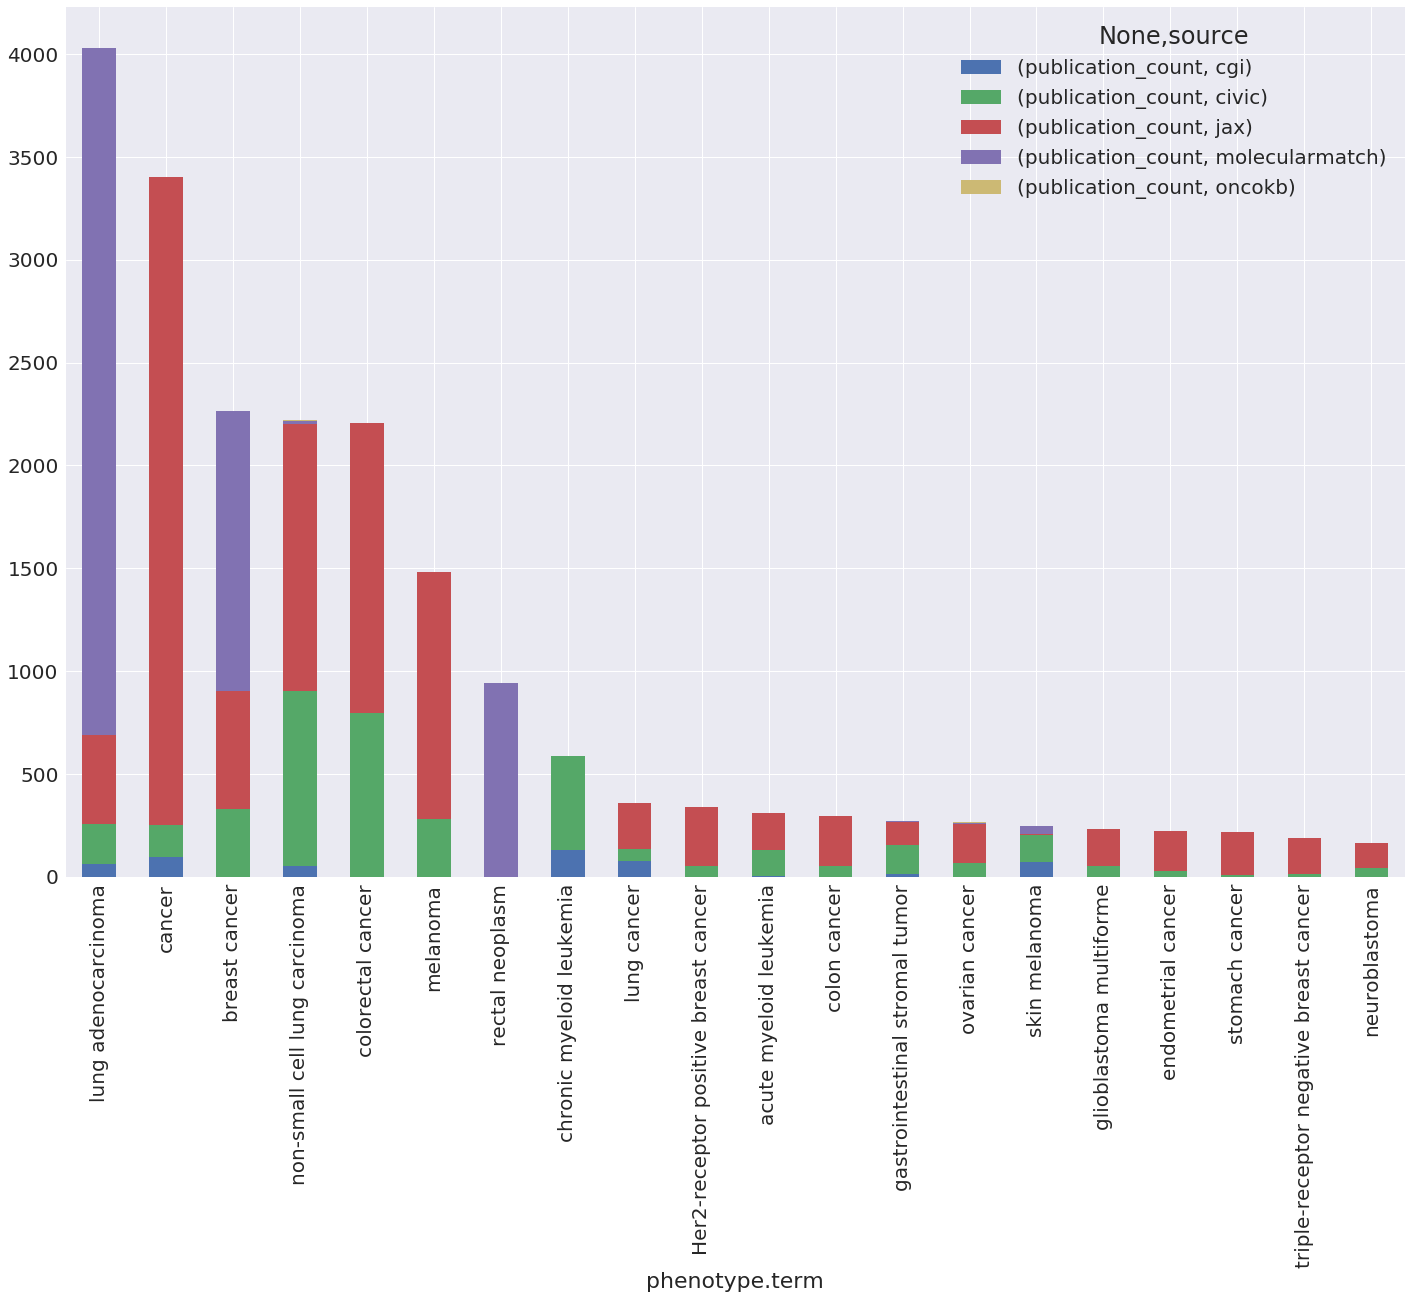

In [5]:
sns.set(font_scale=2)

table = pd.pivot_table(associations_df,
                       index=["phenotype.term","source"],
                       values=['publication_count'],
                       aggfunc=np.sum)
cmp = plt.cm.get_cmap('jet')
s_sort = table.groupby(level=[0]).sum().sort_values(by=['publication_count'],ascending=False)
table = table.reindex(index=s_sort.index, level=0).unstack(fill_value=0)


table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16))


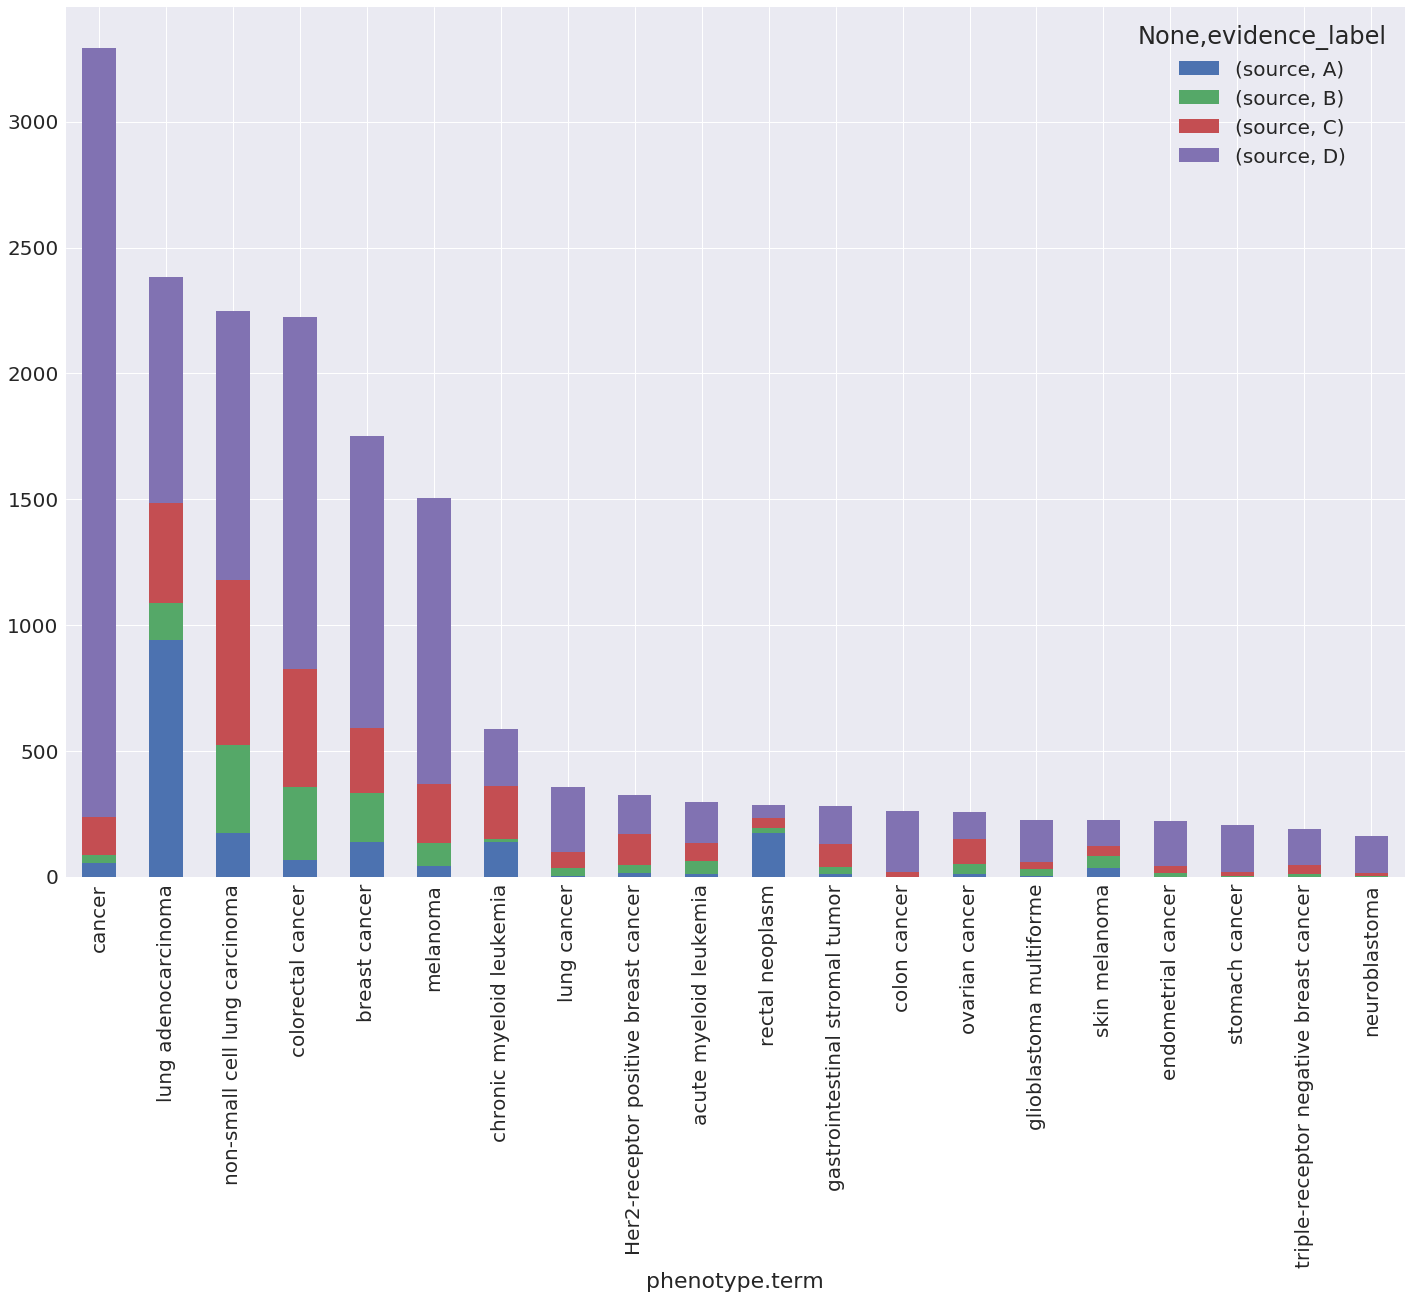

In [18]:
sns.set(font_scale=2)

table = pd.pivot_table(associations_df,
                       index=["phenotype.term","evidence_label"],
                       values=['source'],
                       aggfunc='count')
cmp = plt.cm.get_cmap('jet')
s_sort = table.groupby(level=[0]).sum().sort_values(by=['source'],ascending=False)
table = table.reindex(index=s_sort.index, level=0).unstack(fill_value=0)


table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16))


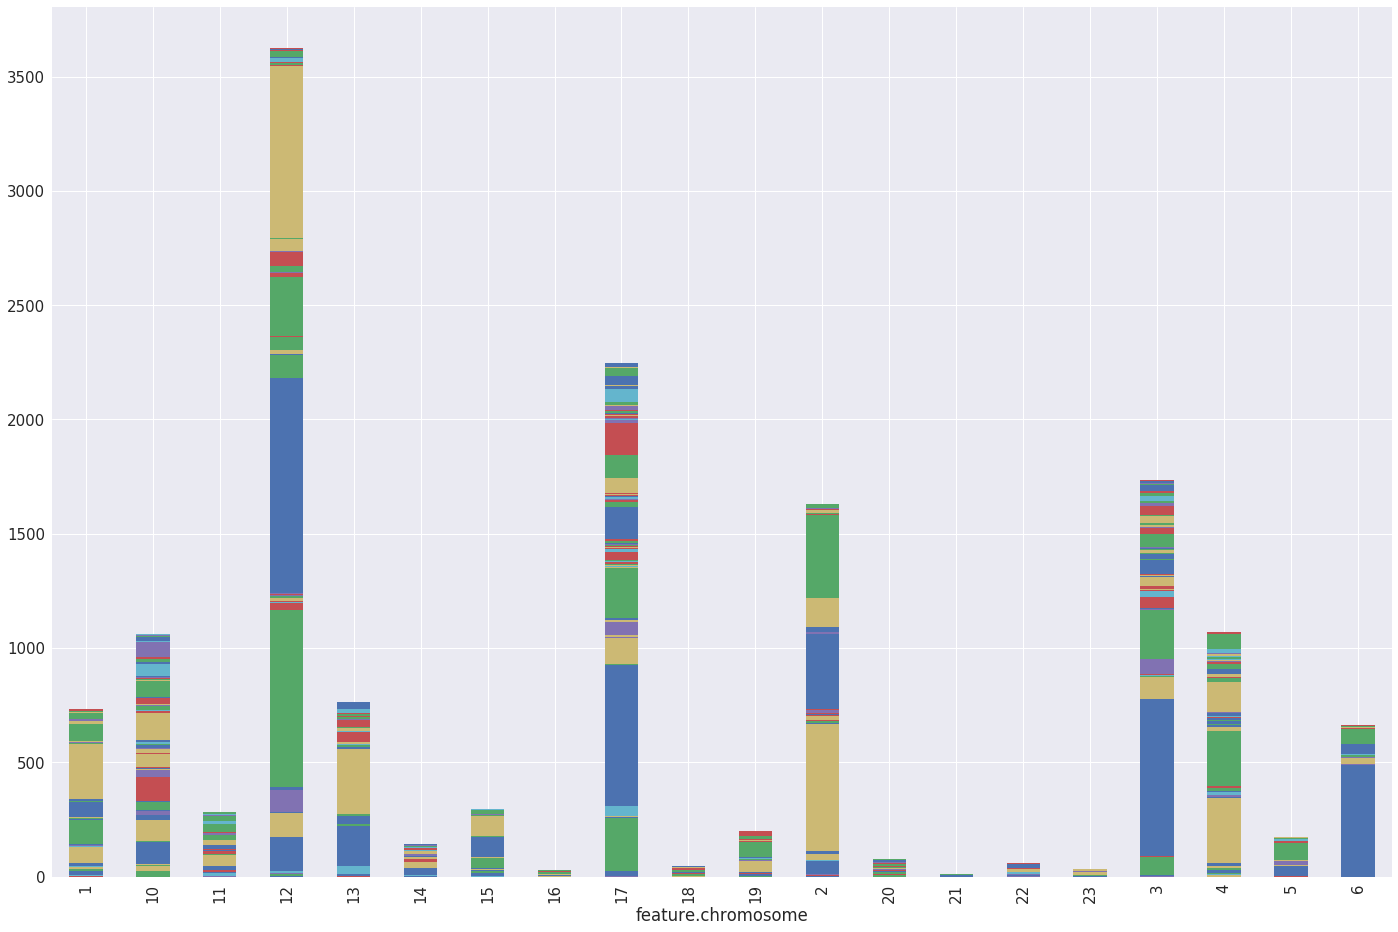

In [40]:
# create a pivot table to sum publication count by phenotype and chromosome
table = pd.pivot_table(associations_df, 
                       values=['publication_count'], 
                       index=['feature.chromosome'],
                       columns=['phenotype.term'], 
                       aggfunc=sum ,
                       fill_value=0) 

table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16), legend=None)
